<a href="https://colab.research.google.com/github/megmarv/PsychoAI-/blob/Emotion-Identification4/ViTModel-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import efficientnet_v2
from einops.layers.tensorflow import Rearrange

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving FER2013.zip to FER2013 (1).zip


In [ ]:
import zipfile
import os

# Extract the uploaded zip file
zip_file = 'FER2013.zip'  # Update with your file name if different
extract_path = '/content/FER2013/'  # Path where the files will be extracted

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify the extraction
os.listdir(extract_path)

['train', 'test']

In [ ]:
# List contents of train and test folders
print(os.listdir(extract_path + 'train'))
print(os.listdir(extract_path + 'test'))

['fear', 'neutral', 'surprise', 'sad', 'happy', 'disgust', 'angry']
['fear', 'neutral', 'surprise', 'sad', 'happy', 'disgust', 'angry']


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerators for training and testing
train_datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)  # Validation split = 20%
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load training data
train_generator = train_datagen.flow_from_directory(
    os.path.join(extract_path, 'train'),  # Path to the train folder
    target_size=(48, 48),  # Resize images to 48x48 as required for ViT
    batch_size=64,
    class_mode='categorical',  # Multi-class classification (emotion categories)
    subset='training'  # Use the training subset
)

# Load validation data
validation_generator = train_datagen.flow_from_directory(
    os.path.join(extract_path, 'train'),  # Path to the train folder
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',  # Multi-class classification
    subset='validation'  # Use the validation subset
)

# Load test data
test_generator = test_datagen.flow_from_directory(
    os.path.join(extract_path, 'test'),  # Path to the test folder
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical'  # Multi-class classification
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Create ViT model (Vision Transformer)
def create_vit_model(input_shape=(48, 48, 3), num_classes=7):
    # Input layer
    inputs = layers.Input(shape=input_shape)

    # Patch extraction
    x = layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same")(inputs)
    x = layers.LayerNormalization()(x)
    x = layers.ReLU()(x)

    # Transformer block
    transformer_layer = layers.MultiHeadAttention(num_heads=4, key_dim=32)
    x = transformer_layer(x, x)
    x = layers.GlobalAveragePooling2D()(x)

    # Fully connected layer
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

# Create the ViT model
model = create_vit_model()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 48, 48, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 24, 24, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 24, 24, 32)     │             64 │ conv2d[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 24, 24, 32)     │              0 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 24, 24, 32)     │         16,800 │ re_lu[0][0],           │
│ (MultiHeadAttention)      │                        │                │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 32)             │              0 │ multi_head_attention[… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │          4,224 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 7)              │            903 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 22,887 (89.40 KB)

 Trainable params: 22,887 (89.40 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 1402s 4s/step - accuracy: 0.2429 - loss: 1.8261 - val_accuracy: 0.2510 - val_loss: 1.7947
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 1475s 4s/step - accuracy: 0.2548 - loss: 1.7972 - val_accuracy: 0.2595 - val_loss: 1.7908
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 1367s 4s/step - accuracy: 0.2551 - loss: 1.7907 - val_accuracy: 0.2608 - val_loss: 1.7814
Epoch 4/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 1456s 4s/step - accuracy: 0.2552 - loss: 1.7825 - val_accuracy: 0.2634 - val_loss: 1.7764
Epoch 5/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 1411s 4s/step - accuracy: 0.2585 - loss: 1.7790 - val_accuracy: 0.2581 - val_loss: 1.7736
Epoch 6/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 1386s 4s/step - accuracy: 0.2591 - loss: 1.7733 - val_accuracy: 0.2573 - val_loss: 1.7766
Epoch 7/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 1428s 4s/step - accuracy: 0.2650 - loss: 1.7713 - val_accuracy: 0.2604 - val_loss: 1.7660
Epoch 8/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 1401s 4s/step - accuracy: 0.2735 - loss: 1.7569 - 

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.2854 - loss: 1.7421
Test Loss: 1.739736795425415, Test Accuracy: 0.2886597812175751


113/113 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report:
               precision    recall  f1-score   support

       angry       0.00      0.00      0.00       958
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.05      0.08      1024
       happy       0.24      0.56      0.34      1774
     neutral       0.00      0.00      0.00      1233
         sad       0.17      0.22      0.19      1247
    surprise       0.11      0.15      0.13       831

    accuracy                           0.20      7178
   macro avg       0.10      0.14      0.10      7178
weighted avg       0.12      0.20      0.14      7178



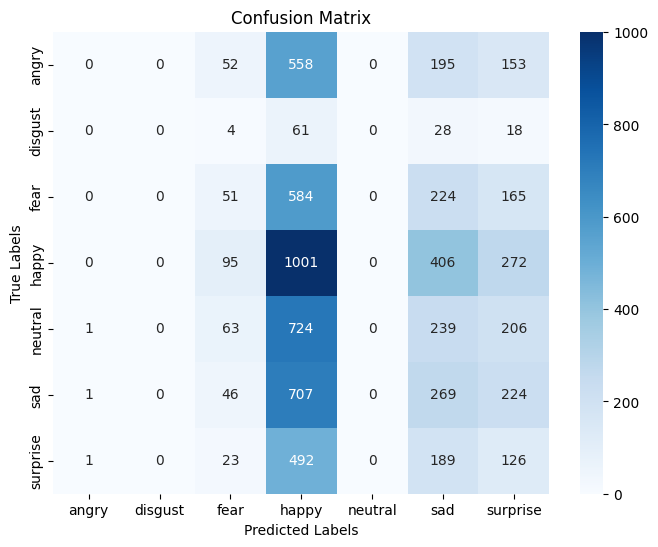


--- Evaluation Summary ---
Accuracy: 0.2016

Confusion Matrix:
 [[   0    0   52  558    0  195  153]
 [   0    0    4   61    0   28   18]
 [   0    0   51  584    0  224  165]
 [   0    0   95 1001    0  406  272]
 [   1    0   63  724    0  239  206]
 [   1    0   46  707    0  269  224]
 [   1    0   23  492    0  189  126]]

--- Classification Report ---
               precision    recall  f1-score   support

       angry       0.00      0.00      0.00       958
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.05      0.08      1024
       happy       0.24      0.56      0.34      1774
     neutral       0.00      0.00      0.00      1233
         sad       0.17      0.22      0.19      1247
    surprise       0.11      0.15      0.13       831

    accuracy                           0.20      7178
   macro avg       0.10      0.14      0.10      7178
weighted avg       0.12      0.20      0.14      7178



In [ ]:
# Step 1: Get predictions from the model
test_predictions = model.predict(test_generator, verbose=1)
test_labels = test_generator.classes
predicted_labels = np.argmax(test_predictions, axis=1)

# Step 2: Import necessary libraries
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Step 3: Generate confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Step 4: Calculate overall accuracy
accuracy = accuracy_score(test_labels, predicted_labels)

# Step 5: Generate classification report with F1 scores
report = classification_report(test_labels, predicted_labels, target_names=test_generator.class_indices.keys())
print("\nClassification Report:\n", report)

# Step 6: Generate confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Step 7: Display evaluation report
evaluation_report = {
    "Accuracy": accuracy,
    "Confusion Matrix": cm,
    "Classification Report": report
}

# Display evaluation summary
print("\n--- Evaluation Summary ---")
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", cm)
print("\n--- Classification Report ---\n", report)